# DC2 Run1.2 object catalog footprint (Spark)
<br>Owner: **S Plaszczynski** (https://github.com/LSSTDESC/DC2-production/issues/299)
<br>Last Verified to Run: **2018-11-18**

The goal of this notebook is to have a QA look a the dc2-data-access produced object_catalog (currently on Run1.2p)
It also illustrates how simple and efficient Spark is.


## load the full Run1.2 catalog from single parquet file

In [176]:
from pyspark.sql import SparkSession

# Initialise our Spark session
spark = SparkSession.builder.getOrCreate()
print("spark session started")

spark session started


In [177]:
object_catalog="/global/cscratch1/sd/plaszczy/Run1.2p/object_catalog/full_catalog.parquet"
df_all=spark.read.parquet(object_catalog)
df_all.printSchema()

root
 |-- snr_u_cModel: double (nullable = true)
 |-- Iyy: double (nullable = true)
 |-- psFluxErr_y: double (nullable = true)
 |-- IxxPSF_u: double (nullable = true)
 |-- magerr_u_cModel: double (nullable = true)
 |-- y: double (nullable = true)
 |-- psf_fwhm_z: double (nullable = true)
 |-- parentObjectId: long (nullable = true)
 |-- mag_z_cModel: double (nullable = true)
 |-- psFlux_r: double (nullable = true)
 |-- mag_g_cModel: double (nullable = true)
 |-- IxxPSF_r: double (nullable = true)
 |-- snr_y_cModel: double (nullable = true)
 |-- Ixx_y: double (nullable = true)
 |-- I_flag_y: boolean (nullable = true)
 |-- tract: long (nullable = true)
 |-- IyyPSF_y: double (nullable = true)
 |-- mag_r: double (nullable = true)
 |-- Ixx: double (nullable = true)
 |-- psFluxErr_z: double (nullable = true)
 |-- Iyy_r: double (nullable = true)
 |-- IyyPSF_g: double (nullable = true)
 |-- IxyPSF: double (nullable = true)
 |-- magerr_z_cModel: double (nullable = true)
 |-- magerr_z: double (nu

In [178]:
#select relevant columns
df=df_all.select("tract","patch","ra","dec")
# and put them in cache
N=df.cache().count()
print("#galaxies={} millions".format(N/1e6))

#galaxies=27.02415 millions


## Look at tracts and patches

In [86]:
df.select("tract").distinct().count() #check all tracts are present

20

This is OK. how many patches per tract?

In [87]:
df.groupBy(["tract","patch"]).count().groupBy("tract").count().\
withColumnRenamed("count","#patches").sort("tract").show()  #groupBy twice, rename and sort

+-----+--------+
|tract|#patches|
+-----+--------+
| 4429|      42|
| 4430|      56|
| 4431|      56|
| 4432|      56|
| 4433|       7|
| 4636|      16|
| 4637|      64|
| 4638|      64|
| 4639|      64|
| 4640|      48|
| 4848|      48|
| 4849|      64|
| 4850|      64|
| 4851|      64|
| 4852|      16|
| 5062|      17|
| 5063|      54|
| 5064|      56|
| 5065|      56|
| 5066|      35|
+-----+--------+



## (ra,dec) footprint

In [10]:
#are there some Nans?
import numpy as np
df.filter(df['ra'].contains(np.nan)).count()

0

No so lets do some basic statistics

In [11]:
df.describe(['ra','dec']).show()

+-------+------------------+-------------------+
|summary|                ra|                dec|
+-------+------------------+-------------------+
|  count|          27024150|           27024150|
|   mean| 55.07647118204146|-29.798815954347592|
| stddev|1.9023769498327734|  1.641899081117175|
|    min| 51.74916962374651| -32.58858724482577|
|    max| 58.36818361208815|-26.947017635210035|
+-------+------------------+-------------------+



We will project galaxies in a Healpix map. For that we define a pandas User Defined Function to call healpy ang2pix function

In [106]:
import pandas as pd
import numpy as np
import healpy as hp
from pyspark.sql.functions import pandas_udf, PandasUDFType

nside=4096
#create the ang2pix user-defined-function. 
#we use pandas_udf because they are more efficient
@pandas_udf('int', PandasUDFType.SCALAR)
def Ang2Pix(ra,dec):
    return pd.Series(hp.ang2pix(nside,np.radians(90-dec),np.radians(ra)))

In [107]:
#add a column of healpix indices
df=df.withColumn("ipix",Ang2Pix("ra","dec"))
#groupby indices and count the number of elements in each group
map_df=df.groupBy("ipix").count()
#statistics per pixel
map_df.describe(['count']).show() 

+-------+------------------+
|summary|             count|
+-------+------------------+
|  count|            151362|
|   mean|178.53985808855592|
| stddev| 57.17730428423143|
|    min|                 1|
|    max|               453|
+-------+------------------+



In [108]:
#back to python world
map_p=map_df.toPandas()

In [109]:
#now data is reduced create the healpy map
map = np.zeros(hp.nside2npix(nside))
map[map_p['ipix'].values]=map_p['count'].values
map[map==0]=hp.UNSEEN

<Figure size 432x288 with 0 Axes>

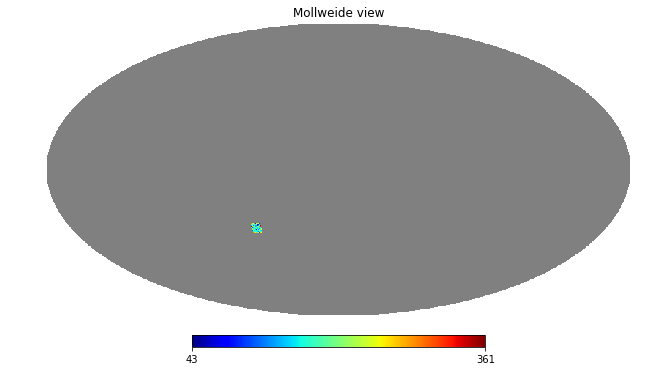

In [117]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.set_cmap('jet')

hp.mollview(map)

from the previous mean ra/dec and count statistics we can zoom on the center and perform a gnomonic projection

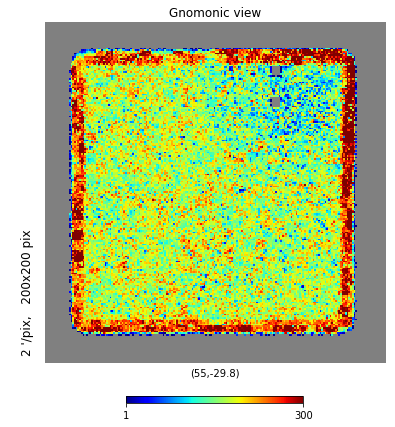

In [118]:
hp.gnomview(map,rot=[55,-29.8],reso=2,max=300)

2 holes. Is this normal? According to https://github.com/LSSTDESC/DC2-analysis/blob/master/tutorials/dm_butler_skymap.ipynb looks like this region belongs to tract=5063

In [119]:
t=df.filter(df.tract==5063).groupBy("patch").count()

In [165]:
t.show(5)

+-----+-----+
|patch|count|
+-----+-----+
|  4,3|26813|
|  3,1|27413|
|  2,6|37756|
|  3,2|28443|
|  0,1|15947|
+-----+-----+
only showing top 5 rows



we go back to the standard python world and create a dictionary of occupancy per patch 

In [137]:
occ=dict(t.toPandas().values)

then fill a 8x8 matrix from these to see which patches are missing

In [143]:
import numpy as np
mat=np.zeros([8,8],'int')
for k in occ.keys():
    counts=occ[k]
    i=int(k[0])
    j=int(k[2])
    mat[i,j]=counts

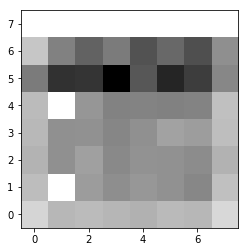

In [163]:
plt.imshow(mat.transpose(),origin='lower',cmap='binary')

we see that the **missing patches are 1,1 and 1,4** (upper row not in survey). we may check there are not indeed in the list (this is lazy evaluation!)

In [175]:
t.filter((t.patch=='1,1')|(t.patch=='1,4')).count()

0